In [15]:
video_id = 'cup/batch-3/2'
# download_dir = './nerf_data'

v_id = 'cup_batch-3_2'

download_dir = './Objectron_data/'+v_id

In [16]:
from os import path
import glob
import os
import struct
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from matplotlib import image


In [17]:
"""Methods for drawing a bounding box on an image."""
import cv2
import numpy as np

import objectron.dataset.box as Box

_LINE_TICKNESS = 10
_POINT_RADIUS = 10
_COLORS = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (128, 128, 0),
    (128, 0, 128),
    (0, 128, 128),
    (255, 255, 255),
    (0, 0, 0),
    (255, 0, 255),
]

def project_points(points, projection_matrix, view_matrix, width, height):
    p_3d = np.concatenate((points, np.ones_like(points[:, :1])), axis=-1).T
    p_3d_cam = np.matmul(view_matrix, p_3d)
    p_2d_proj = np.matmul(projection_matrix, p_3d_cam)
    # Project the points
    p_2d_ndc = p_2d_proj[:-1, :] / p_2d_proj[-1, :]
    p_2d_ndc = p_2d_ndc.T

    # Convert the 2D Projected points from the normalized device coordinates to pixel values
    x = p_2d_ndc[:, 1]
    y = p_2d_ndc[:, 0]
    pixels = np.copy(p_2d_ndc)
    pixels[:, 0] = ((1 + x) * 0.5) * width
    pixels[:, 1] = ((1 + y) * 0.5) * height    
    pixels = pixels.astype(int)
    return pixels

def draw_annotation_on_image(image,
                             object_annotations,
                             num_keypoints):
  """Draw annotation on the image."""
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  keypoints = np.split(object_annotations, np.array(np.cumsum(num_keypoints)))
  keypoints = [points.reshape(-1, 3) for points in keypoints]
  h, w, _ = image.shape
  num_objects = len(num_keypoints)
  # The keypoints are [x, y, d] where `x` and `y` are normalized (`uv`-system)\
  # and `d` is the metric distance from the center of the camera. Convert them
  # keypoint's `xy` value to pixel.
  keypoints = [
      np.multiply(keypoint, np.asarray([w, h, 1.], np.float32)).astype(int)
      for keypoint in keypoints
  ]

  def draw_face(object_id, face, color):
    start = keypoints[object_id][face[0], :]
    end = keypoints[object_id][face[2], :]
    cv2.line(image, (start[0], start[1]), (end[0], end[1]), color,
             _LINE_TICKNESS)
    start = keypoints[object_id][face[1], :]
    end = keypoints[object_id][face[3], :]
    cv2.line(image, (start[0], start[1]), (end[0], end[1]), color,
             _LINE_TICKNESS)

  for object_id in range(num_objects):
    num_keypoint = num_keypoints[object_id]
    edges = Box.EDGES
    hidden = [False] * Box.NUM_KEYPOINTS
    draw_face(object_id, Box.FACES[Box.FRONT_FACE_ID], _COLORS[7])
    draw_face(object_id, Box.FACES[Box.TOP_FACE_ID], _COLORS[8])

    for kp_id in range(num_keypoint):
      kp_pixel = keypoints[object_id][kp_id, :]
      # If a keypoint is hidden (e.g. a subset of a larger skeleton family) do
      # not visualize it.
      if not hidden[kp_id]:
        cv2.circle(image, (kp_pixel[0], kp_pixel[1]), _POINT_RADIUS,
                   _COLORS[object_id % len(_COLORS)], -1)

    for edge in edges:
      # This if statement is for backward compatibility, where we might later
      # add more edges/keypoints to the skeletons.
      if edge[0] < num_keypoint and edge[1] < num_keypoint:
        start_kp = keypoints[object_id][edge[0], :]
        end_kp = keypoints[object_id][edge[1], :]
        if not hidden[edge[0]] and not hidden[edge[1]]:
          cv2.line(image, (start_kp[0], start_kp[1]), (end_kp[0], end_kp[1]),
                   _COLORS[object_id % len(_COLORS)], _LINE_TICKNESS)
  return image

In [18]:
public_url = "https://storage.googleapis.com/objectron"
os.makedirs(download_dir, exist_ok=True)
video_filename = f'{public_url}/videos/{video_id}/video.MOV'
public_url = "https://storage.googleapis.com/objectron"
urls = [f'{public_url}/videos/{video_id}/video.MOV',
       f'{public_url}/videos/{video_id}/sfm_arframe.pbdata',
       f'{public_url}/annotations/{video_id}.pbdata']
for url in urls:
    with open(path.join(download_dir, path.basename(url)), "wb") as f:
        f.write(requests.get(url).content)

In [3]:
ls -sh1 ./Objectron_data/cup_batch-8_32

total 25M
212K cup_batch-8_32.pbdata
640K cup_batch-8_32_sfm_arframe.pbdata
 12K images/
 24M video.MOV


In [19]:
%%bash
$v_id = v_id
cd ./Objectron_data/cup_batch-3_2
mkdir -p "images"
ffmpeg -i video.MOV -vsync vfr -vf "scale=iw:ih" -start_number 0 "images/%05d.png"

bash: line 1: =: command not found
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-l

In [4]:
sequence_filenames = sorted(glob.glob('Objectron_data/'+v_id+'/images/*.png'))
geometry_filename = 'Objectron_data/'+v_id+'geometry.pbdata'
sfm_arframe_filename = 'Objectron_data/'+v_id+'/cup_batch-8_32_sfm_arframe.pbdata'
annotation_file = 'Objectron_data/'+v_id+'/cup_batch-8_32.pbdata'

# sequence_filenames = sorted(glob.glob('/home/zubair/bottle_batch-1_37/images_12/*.png'))
# sfm_arframe_filename = '/home/zubair/bottle_batch-1_37/bottle_batch-1_37_sfm_arframe.pbdata'
# annotation_file = '/home/zubair/bottle_batch-1_37/bottle_batch-1_37.pbdata'

In [5]:
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol

def load_frame_data(geometry_filename):
    # See get_geometry_data in objectron-geometry-tutorial.ipynb
    frame_data = []
    with open(geometry_filename, 'rb') as pb:
        proto_buf = pb.read()

        i = 0
        while i < len(proto_buf):
            msg_len = struct.unpack('<I', proto_buf[i:i + 4])[0]
            i += 4
            message_buf = proto_buf[i:i + msg_len]
            i += msg_len
            frame = ar_metadata_protocol.ARFrame()
            frame.ParseFromString(message_buf)
            frame_data.append(frame)
    return frame_data

frame_data = load_frame_data(sfm_arframe_filename)

(1920, 1440, 3)


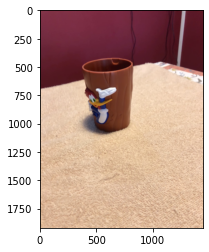

(1440, 1920, 3)


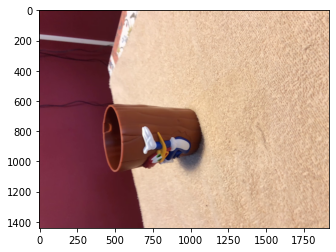

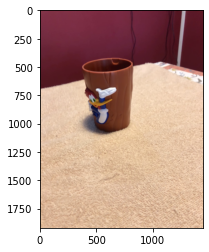

In [6]:
from PIL import Image
import torch
im = sequence_filenames[0]
img = Image.open(im) 
print(np.array(img).shape)
import numpy as np

plt.imshow(np.array(img))
plt.show()

img_rot = img.transpose(Image.ROTATE_90)

import matplotlib.pyplot as plt
print(np.array(img_rot).shape)
plt.imshow(np.array(img_rot))
plt.show()

img_tensor = torch.tensor(np.array(img_rot))

import torchvision.transforms as T

# rotated_back_tensor = T.functional.rotate(img_tensor, -90)
# print(img_tensor.shape)
rotated_back_tensor = torch.rot90(img_tensor, dims=(1, 0))
# rotated_back = np.rot90(np.array(img_rot), axes=(1, 0))
plt.imshow(np.array(rotated_back_tensor.numpy()))
plt.show()

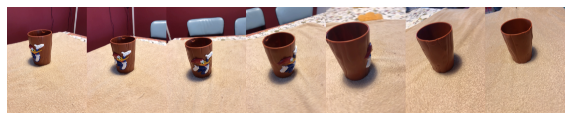

334 PNG files found


In [7]:
step = 50

plt.figure(figsize=(10,3))
plt.imshow(np.concatenate([image.imread(filename) for filename in sequence_filenames[::step]], axis=1))
plt.axis('off')
plt.show()
print(f'{len(sequence_filenames)} PNG files found')

In [8]:
def make_poses_bounds_array(frame_data, near=0.2, far=10):
    # See https://github.com/Fyusion/LLFF#using-your-own-poses-without-running-colmap
    # Returns an array of shape (N, 17).
    rows = []
    all_c2w = []
    for frame in frame_data:
        camera = frame.camera        
#         print(camera.intrinsics)
        focal = camera.intrinsics[0]
        
#         print(np.array(camera.intrinsics).reshape(3,3))
        intrinsics = np.array(camera.intrinsics).reshape(3,3)
#         print(camera.image_resolution_width)
#         print(camera.image_resolution_height)
        fx = intrinsics[0,0]
        fy = intrinsics[1,1]
        cx = intrinsics[0,2]
        cy = intrinsics[1,2]
        print(fx,fy,cx,cy)
#         print("focal", focal)
#         print("camera view matrix", np.array(camera.view_matrix).reshape(4,4))
        projection = np.array(camera.projection_matrix).reshape(4,4)[0,0]
#         print("projection 0", projection, focal / (1920/2))
#         print("camera projection matrix", np.array(camera.projection_matrix).reshape(4,4))
        cam_to_world = np.array(camera.transform).reshape(4,4)
#         print("cam to world",  cam_to_world)
        all_c2w.append(cam_to_world)
    return all_c2w, focal
        
frame_data = load_frame_data(sfm_arframe_filename)

poses = make_poses_bounds_array(frame_data, near=0.2, far=10)

1555.622314453125 1555.622314453125 960.0 720.0
1555.257568359375 1555.257568359375 960.0 720.0
1556.2789306640625 1556.2789306640625 960.0 720.0
1555.4739990234375 1555.4739990234375 960.0 720.0
1554.9769287109375 1554.9769287109375 960.0 720.0
1556.6431884765625 1556.6431884765625 960.0 720.0
1555.77783203125 1555.77783203125 960.0 720.0
1556.093994140625 1556.093994140625 960.0 720.0
1556.8406982421875 1556.8406982421875 960.0 720.0
1561.77197265625 1561.77197265625 960.0 720.0
1566.2119140625 1566.2119140625 960.0 720.0
1570.3785400390625 1570.3785400390625 960.0 720.0
1574.632080078125 1574.632080078125 960.0 720.0
1571.6788330078125 1571.6788330078125 960.0 720.0
1572.927734375 1572.927734375 960.0 720.0
1569.2685546875 1569.2685546875 960.0 720.0
1565.477783203125 1565.477783203125 960.0 720.0
1558.7083740234375 1558.7083740234375 960.0 720.0
1557.380859375 1557.380859375 960.0 720.0
1556.057861328125 1556.057861328125 960.0 720.0
1546.76318359375 1546.76318359375 960.0 720.0
15

In [9]:
def project_points(points, projection_matrix, view_matrix, width, height):
    p_3d = np.concatenate((points, np.ones_like(points[:, :1])), axis=-1).T
    p_3d_cam = np.matmul(view_matrix, p_3d)
    p_2d_proj = np.matmul(projection_matrix, p_3d_cam)
    # Project the points
    p_2d_ndc = p_2d_proj[:-1, :] / p_2d_proj[-1, :]
    p_2d_ndc = p_2d_ndc.T

    # Convert the 2D Projected points from the normalized device coordinates to pixel values
    x = p_2d_ndc[:, 1]
    y = p_2d_ndc[:, 0]
    pixels = np.copy(p_2d_ndc)
    pixels[:, 0] = ((1 + x) * 0.5) * width
    pixels[:, 1] = ((1 + y) * 0.5) * height    
    pixels = pixels.astype(int)
    return pixels


def get_frame_annotation(sequence, frame_id):
  """Grab an annotated frame from the sequence."""
  data = sequence.frame_annotations[frame_id]
  object_id = 0
  object_keypoints_2d = []
  object_keypoints_3d = []
  object_rotations = []
  object_translations = []
  object_scale = []
  num_keypoints_per_object = []
  object_categories = []
  annotation_types = []
  # Get the camera for the current frame. We will use the camera to bring
  # the object from the world coordinate to the current camera coordinate.
  camera = np.array(data.camera.transform).reshape(4, 4)

  for obj in sequence.objects:
    rotation = np.array(obj.rotation).reshape(3, 3)
    translation = np.array(obj.translation)
    object_scale.append(np.array(obj.scale))
    transformation = np.identity(4)
    transformation[:3, :3] = rotation
    transformation[:3, 3] = translation
    obj_cam = np.matmul(camera, transformation)
    object_translations.append(obj_cam[:3, 3])
    object_rotations.append(obj_cam[:3, :3])
    object_categories.append(obj.category)
    annotation_types.append(obj.type)

  keypoint_size_list = []
  for annotations in data.annotations:
    num_keypoints = len(annotations.keypoints)
    keypoint_size_list.append(num_keypoints)
    for keypoint_id in range(num_keypoints):
      keypoint = annotations.keypoints[keypoint_id]
      object_keypoints_2d.append(
          (keypoint.point_2d.x, keypoint.point_2d.y, keypoint.point_2d.depth))
      object_keypoints_3d.append(
          (keypoint.point_3d.x, keypoint.point_3d.y, keypoint.point_3d.z))
    num_keypoints_per_object.append(num_keypoints)
    object_id += 1
  return (object_keypoints_2d, object_categories, keypoint_size_list,
          annotation_types)


def grab_frame(video_file, frame_ids):
  """Grab an image frame from the video file."""
  frames = []
  capture = cv2.VideoCapture(video_file)
  height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  capture.release()
    
  print("width, height", width, height)
  frame_size = width * height * 3

  for frame_id in frame_ids:
    frame_filter = r'select=\'eq(n\,{:d})\''.format(frame_id)
    command = [
        'ffmpeg', '-i', video_file, '-f', 'image2pipe', '-vf', frame_filter,
        '-pix_fmt', 'rgb24', '-vcodec', 'rawvideo', '-vsync', 'vfr', '-'
    ]
    pipe = subprocess.Popen(
        command, stdout=subprocess.PIPE, bufsize = 151 * frame_size)
    current_frame = np.fromstring(
        pipe.stdout.read(frame_size), dtype='uint8').reshape(width, height, 3)
    pipe.stdout.flush()

    frames.append(current_frame)
  return frames

In [10]:
# The annotations are stored in protocol buffer format. 
from objectron.schema import object_pb2 as object_protocol
from objectron.schema import annotation_data_pb2 as annotation_protocol
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol
from objectron.dataset import box as Box
# from objectron.dataset import graphics
import subprocess

frame_id = 28
with open(annotation_file, 'rb') as pb:
    sequence = annotation_protocol.Sequence()
    sequence.ParseFromString(pb.read())
    frame = grab_frame(video_filename, [frame_id])

    im = sequence_filenames[0]
    img = Image.open(im) 
    img = np.array(img)
    annotation, cat, num_keypoints, types = get_frame_annotation(sequence, frame_id)
    print(annotation)
    image = draw_annotation_on_image(frame[0], annotation, num_keypoints)
#     image = graphics.draw_annotation_on_image(img, annotation, num_keypoints)
    print("image", image.shape)
    imgplot = plt.imshow(image)

NameError: name 'video_filename' is not defined

In [ ]:
adjust_matrix = np.array(
    [[0.,   1.,   0., 0],
     [1.,   0.,   0., 0],
     [0.,   0.,  -1., 0],
     [0.,   0.,  0., 1]])
     
print(np.linalg.inv(adjust_matrix))

In [35]:
import _pickle as cPickle
import numpy as np
import cv2
import colorsys
import glob
import os
import cv2
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

def get_valid_masks_index(mask_out, threshold):
    index_centers = []
    areas = []
    for m in range(mask_out.shape[2]):
        pos = np.where(mask_out[:,:, m]>0)
        center_x = np.average(pos[0])
        center_y = np.average(pos[1])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        areas.append(((ymax-ymin)* (xmax-xmin))/100)
        index_centers.append([center_x, center_y])

    index = np.argmax(areas)
    index_centers = np.array(index_centers)
    print("areas",areas)
    valid_mask_indices = []
    for j in range(len(index_centers)):
        if areas[j] <20:
            continue
        if j == index:
            valid_mask_indices.append(j)
            continue
        point = index_centers[index]
        distance = np.linalg.norm(index_centers[j]-point)
        print("distance", distance)
        if distance<threshold:
            valid_mask_indices.append(j)
    return valid_mask_indices

In [45]:

results_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-11_6/results'
image_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-11_6/images_3'
image_save_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-11_6/images_12'


image_files = os.listdir(image_dir)
result_files = os.listdir(results_dir)
image_files.sort()
result_files.sort()

save_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-11_6/output'
os.makedirs(save_dir, exist_ok = True)
for num, (img_file, result_file) in enumerate(zip(image_files, result_files)):
    if num !=70:
        continue
    print("num",num)
    print(result_file)
    print(os.path.join(results_dir, result_file))
    with open(os.path.join(results_dir, result_file) , 'rb') as f:
      mrcnn_result = cPickle.load(f)
    img = cv2.imread(os.path.join(image_dir, img_file))
    print(mrcnn_result)
    mask_out = mrcnn_result['masks']
    print(mask_out)
    valid_mask_indices = get_valid_masks_index(mask_out, 173)
    colors = random_colors(mrcnn_result['masks'].shape[2])

    import matplotlib.pyplot as plt
    total_mask = np.zeros((img.shape[0], img.shape[1]), dtype = bool)
    for i in range(mask_out.shape[2]):
#         plt.imshow(mask_out[:,:,i])
#         plt.show()
        if i in valid_mask_indices:
            total_mask = np.logical_or(total_mask, mask_out[:,:,i])
    
    seg_masks = total_mask
    print(total_mask.shape)
    seg_masks = seg_masks.astype(np.uint8)
    seg_masks = cv2.resize(seg_masks,(120,160), interpolation=cv2.INTER_NEAREST)
    seg_masks = seg_masks.astype(np.uint8)
    print(seg_masks.shape)
    plt.imshow(seg_masks)
    plt.show()
    seg_write_name = 'mask_'+img_file
    cv2.imwrite(os.path.join(image_save_dir,seg_write_name ), seg_masks* 255)
#     plt.imshow(total_mask)
    fig = plt.figure()
    fig.set_size_inches(4.8, 6)
    plt.axis('off')
#     plt.show()
    print("total_mask", total_mask.shape)
    print("img", img.shape)
    img = apply_mask(img, total_mask, colors[i])

    plt.imshow(img)
    plt.savefig(os.path.join(save_dir, 'masks'+str(num)), bbox_inches='tight')
#     plt.show()

    

num 70
results_00070.pkl
/home/zubair/nerf_pl/Objectron_data/camera_batch-11_6/results/results_00070.pkl
{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(640, 480, 0), dtype=float64)}
[]


ValueError: attempt to get argmax of an empty sequence

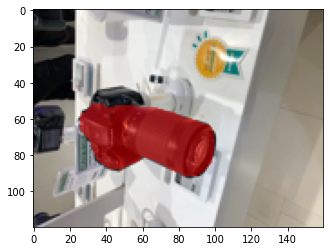

In [17]:
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
colors = random_colors(1)
image_save_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-2_1/images_12'
mask_save_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-2_1/masks_12'

img_pil = Image.open(os.path.join(image_save_dir, '00000.png'))
img_pil = img_pil.transpose(Image.ROTATE_90) 
img = cv2.imread(os.path.join(image_save_dir, '00000.png'))
mask = cv2.imread(os.path.join(mask_save_dir, 'mask_00000.png'), cv2.IMREAD_GRAYSCALE)

img = np.rot90(np.array(img), axes=(1,0))

mask = np.rot90(np.array(mask), axes=(0,1))
mask = mask>0
img = apply_mask(np.array(img_pil), mask, colors[0])

plt.imshow(img)
    

In [7]:
import os

name = '/home/ubuntu/nerf_pl/data/objectron/camera/camera_batch-2_1/images_12/00000.png'
print(os.path.split(name)[1].split('.')[])
        

SyntaxError: invalid syntax (<ipython-input-7-817e69f10825>, line 4)